<a href="https://colab.research.google.com/github/Vineet2107/EEG_Pipeline/blob/main/mainfile_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

0.23.4


In [13]:
pip install mne

In [15]:
#The files we will be loading
#files = ['10_1', '10_2', '12_1', '12_2', '13_1', '13_2', '14_1', '14_2', '15_1', '15_2', '16_1', '16_2', '21_1', '21_2', '22_1', '22_2', '23_1', '23_2', '28_1', '28_2', '31_1', '31_2', '32_1', '32_2', '33_1', '33_2', '34_1', '34_2', '35_1', '35_2', '46_1', '46_2', '47_1', '47_2', '48_1', '48_2', '49_1', '49_2', '50_1', '50_2', '69_1', '69_2', '70_1', '70_2', '71_1', '71_2', '72_1', '72_2']
files = ['10_1', '10_2', '12_1', '12_2', '13_1', '13_2', '28_1', '28_2', '31_1', '31_2', '32_1', '32_2']

print(len(files))

12


In [16]:
#Paths Arush
path = {}
for f in files:
    path[f] = '/content/drive/MyDrive/eeg/sub-AB10_eeg_sub-AB10_task-gonogo_run-1_eeg.set'.format(f[0:-2], f[0:-2], f[-1])
    
path_channels_tsv = '/content/drive/MyDrive/eeg/sub-AB10_eeg_sub-AB10_task-gonogo_run-1_channels.tsv'

In [17]:
#Loading raw data
unclean_raw = {}
for f in files:
    unclean_raw[f] = mne.io.read_raw_eeglab(path[f], eog=(), preload=True, uint16_codec=None, verbose=None)

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


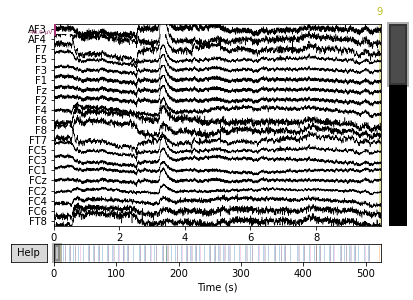

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


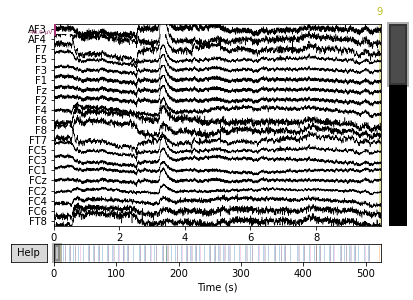

In [18]:

#plotting raw data
# rawab6_1.plot();
# rawab6_2.plot();
unclean_raw['10_1'].plot();
# rawab10_2.plot();
unclean_raw['12_1'].plot();
# rawab12_2.plot();
# rawab13_1.plot();
# rawab13_2.plot();
# rawab28_1.plot();
# rawab28_2.plot();
# rawab31_1.plot();
# rawab31_2.plot();
# rawab32_1.plot();
# rawab32_2.plot();

In [19]:
#get type of channels from tsv file
import pandas as pd
channel_types_tsv = pd.read_csv(path_channels_tsv, delimiter = '\t')

def get_channel_types_dic(channel_types_tsv):
    channel_types = {}
    for i in range(channel_types_tsv.shape[0]):
        channel_types[channel_types_tsv['name'][i]] = channel_types_tsv['type'][i].lower()
    reassign_dic = {'HEO':'eog', 'VEO':'eog', 'R-Dia-X-(mm)':'misc', 'R-Dia-Y-(mm)':'misc'}
    for k in list(reassign_dic.keys()):
        if k in list(channel_types):
            channel_types[k] = reassign_dic[k]
    return channel_types

channel_types = get_channel_types_dic(channel_types_tsv)
channel_types

{'AF3': 'eeg',
 'AF4': 'eeg',
 'C1': 'eeg',
 'C2': 'eeg',
 'C3': 'eeg',
 'C4': 'eeg',
 'C5': 'eeg',
 'C6': 'eeg',
 'CB1': 'eeg',
 'CB2': 'eeg',
 'CP1': 'eeg',
 'CP2': 'eeg',
 'CP3': 'eeg',
 'CP4': 'eeg',
 'CP5': 'eeg',
 'CP6': 'eeg',
 'CPz': 'eeg',
 'Cz': 'eeg',
 'EKG': 'ecg',
 'F1': 'eeg',
 'F2': 'eeg',
 'F3': 'eeg',
 'F4': 'eeg',
 'F5': 'eeg',
 'F6': 'eeg',
 'F7': 'eeg',
 'F8': 'eeg',
 'FC1': 'eeg',
 'FC2': 'eeg',
 'FC3': 'eeg',
 'FC4': 'eeg',
 'FC5': 'eeg',
 'FC6': 'eeg',
 'FCz': 'eeg',
 'FT7': 'eeg',
 'FT8': 'eeg',
 'Fz': 'eeg',
 'HEO': 'eog',
 'M1': 'eeg',
 'M2': 'eeg',
 'O1': 'eeg',
 'O2': 'eeg',
 'Oz': 'eeg',
 'P1': 'eeg',
 'P2': 'eeg',
 'P3': 'eeg',
 'P4': 'eeg',
 'P5': 'eeg',
 'P6': 'eeg',
 'P7': 'eeg',
 'P8': 'eeg',
 'PO3': 'eeg',
 'PO4': 'eeg',
 'PO5': 'eeg',
 'PO6': 'eeg',
 'PO7': 'eeg',
 'PO8': 'eeg',
 'POz': 'eeg',
 'Pz': 'eeg',
 'R-Dia-X-(mm)': 'misc',
 'R-Dia-Y-(mm)': 'misc',
 'T7': 'eeg',
 'T8': 'eeg',
 'TP7': 'eeg',
 'TP8': 'eeg',
 'VEO': 'eog'}

In [20]:
#assigning channel types
for f in files:
    unclean_raw[f].set_channel_types(channel_types)

In [21]:
#filtering the signals
for f in files:
    unclean_raw[f].filter(0.5, 60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

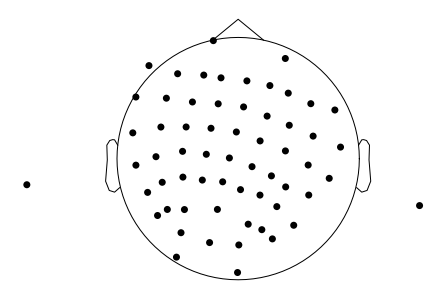

In [22]:
unclean_raw['12_1'].plot_sensors(ch_type = 'eeg', sphere = 10);
# # rawab12_2.plot_sensors(ch_type = 'eeg', sphere = 10);

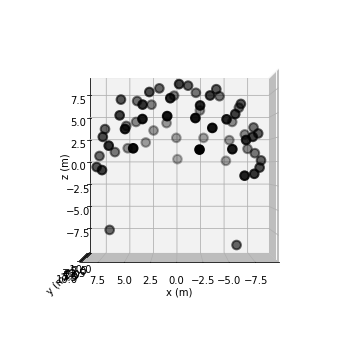

In [23]:
unclean_raw['12_1'].plot_sensors(ch_type = 'eeg', kind = '3d');
# # rawab12_2.plot_sensors(ch_type = 'eeg', kind = '3d');

In [24]:
unclean_raw['10_1']

<RawEEGLAB | sub-AB10_eeg_sub-AB10_task-gonogo_run-1_eeg.set, 66 x 262640 (525.3 s), ~132.3 MB, data loaded>

In [25]:
#Creating copy
raw = {}
for f in files:
    raw[f] = unclean_raw[f].copy()

In [26]:
#Creating ICA objects
ica = {}
for f in files:
    ica[f] = mne.preprocessing.ICA(n_components = 20, random_state = 42)

<ipython-input-26-d419cf7d697f>:4: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica[f] = mne.preprocessing.ICA(n_components = 20, random_state = 42)
<ipython-input-26-d419cf7d697f>:4: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica[f] = mne.preprocessing.ICA(n_components = 20, random_state = 42)
<ipython-input-26-d419cf7d697f>:4: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica[f] = mne.preprocessing.ICA(n_components = 20, random_state = 42)
<ipython-input-26-d

In [27]:
#Fitting ICA objects
for f in files:
    ica[f].fit(raw[f])

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 17.4s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.6s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.2s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.1s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.3s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.1s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.1s.
Fitting ICA to data 

Creating RawArray with float64 data, n_channels=23, n_times=262640
    Range : 0 ... 262639 =      0.000 ...   525.278 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


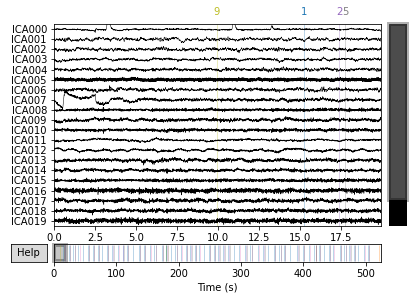

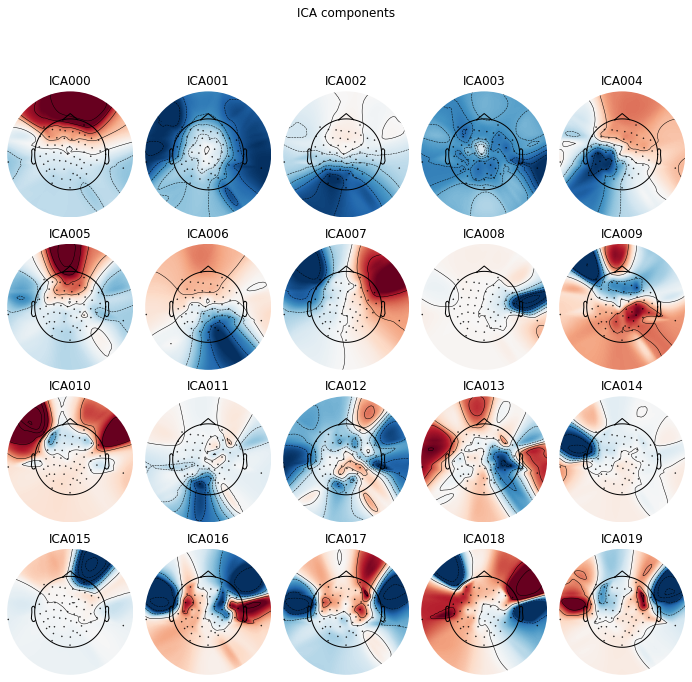

[<MNEFigure size 702x696.24 with 20 Axes>]

In [28]:
#plotting sources and components
ica['10_1'].plot_sources(raw['10_1'])
ica['10_2'].plot_components(outlines = 'head', sphere = 10, ch_type = 'eeg')

In [33]:
#To find and mark bad components
def mark_artifacts(ica, raw):
    ica.exclude = []
    ica.detect_artifacts(raw)
    eeg_bads = list(ica.exclude)
    ecg_bads = ica.find_bads_ecg(raw)[0]
    eog_bads = ica.find_bads_eog(raw)[0]
    ica.exclude = list(set(eeg_bads+ecg_bads+eog_bads))


In [34]:
#Marking bad components
for f in files:
    mark_artifacts(ica[f], raw[f])

    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    3, 3, 11
    Removing duplicate indices...
Ready.
Using threshold: 0.23 for CTPS ECG detection
Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Number of ECG events detected : 550 (average pulse 62 / min.)
Not setting metadata
Not setting metadata
550 matching events found
No baseline correction applied
Loading data for 550 events and 501 original time points

Creating RawArray with float64 data, n_channels=23, n_times=262640
    Range : 0 ... 262639 =      0.000 ...   525.278 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


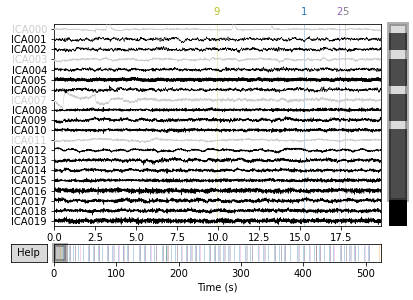

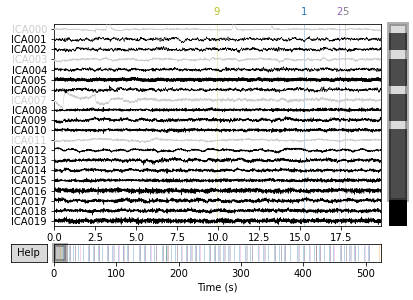

In [35]:
ica['10_1'].plot_sources(raw['10_1'])

In [36]:
#Applying ica
for f in files:
    ica[f].apply(raw[f], exclude = ica[f].exclude)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing o

In [37]:
events = {}
for f in files:
    events[f] = mne.events_from_annotations(raw[f])

Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']
Used Annotations descriptions: ['1', '10', '11', '2', '3', '4', '5', '9']


In [38]:
#Creating event id Dictionary
event_id = {
    "taskstart" : '9',
    "cue" : "1",
    "go" : "2",
    "button press" : "5",
    "no-go" : "4",
    "task end": "10",
    "error 1" : "3",
    "error 2" : "6",
    "error 3" : "7",
    "error 4" : "8",
    "error 5" : "11"
}
event_id

{'button press': '5',
 'cue': '1',
 'error 1': '3',
 'error 2': '6',
 'error 3': '7',
 'error 4': '8',
 'error 5': '11',
 'go': '2',
 'no-go': '4',
 'task end': '10',
 'taskstart': '9'}

In [39]:
#Creating epochs
epochs = {}
for f in files:
    epochs[f] = mne.Epochs(raw[f],
                   events = events[f][0],
                   event_id = events[f][1],)

Not setting metadata
Not setting metadata
155 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
155 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
155 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
155 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
155 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
155 matching events found
Setting base

Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
Loading data for 20 events and 351 original time points ...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


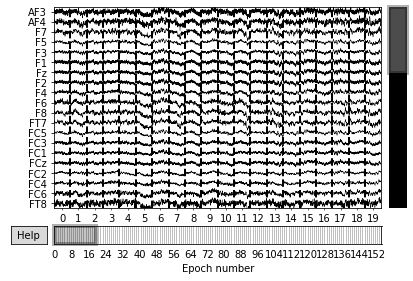

In [40]:
epochs['10_1'].plot();

In [41]:
epochs['10_1'].get_data(picks = 'eeg').shape

Loading data for 155 events and 351 original time points ...


(155, 61, 351)

In [42]:
#to fix event ids
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]
def fix_event_ids(epochs, events):
    for i in range(epochs.events.shape[0]):
        epochs.events[i][2] = int(get_keys_from_value(events[1], epochs.events[i][2])[0])

In [43]:
#fix event ids
for f in files:
    fix_event_ids(epochs[f], events[f])

In [44]:
#Loading important libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
#Getting epoch data
datadic = {}
for f in files:
    datadic[f] = epochs[f].get_data(picks = 'eeg')


Loading data for 155 events and 351 original time points ...
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped
Loading data for 155 events and 351 original time points ...
0 bad epochs dropped


In [46]:
#Concatenating data
data = np.concatenate(list(datadic.values()), 
                      axis = 0)
print(data.shape)

#Changing the shape of data from (events, channel, time points) to (events, time points, channel)
datars = np.zeros((data.shape[0], data.shape[2], data.shape[1]))
for i in range(datars.shape[0]):
    datars[i] = np.transpose(data[i])
    
dims_lstm_1 = datars.shape[1]
dims_lstm_2 = datars.shape[2]
print(dims_lstm_1, "X", dims_lstm_2)
datars.shape

(1860, 61, 351)
351 X 61


(1860, 351, 61)

In [47]:
n_trials = data.shape[0]


data = data.reshape(n_trials, -1)
print(data.shape)
dims_ip = data.shape[1]
dims_ip


(1860, 21411)


21411

In [48]:
#Getting y
ydic = {}
for f in files:
    ydic[f] = epochs[f].events[:, 2]
y = np.concatenate(list(ydic.values()), axis = 0)

In [49]:
#Preparing main dataset
y = y.reshape(-1, 1)
# y = y[...,np.newaxis]
datarscopy = datars.copy()
datarscopy = datarscopy.reshape(datars.shape[0], -1)

print(datars.shape)
print(y.shape)
main_dataset = np.concatenate((datarscopy, y), axis = 1)
print(main_dataset.shape)

#Defining main x and y for training
main_x = main_dataset[:, :-1]
main_y = main_dataset[:, -1]
print(main_x.shape)
print(main_y.shape)


(1860, 351, 61)
(1860, 1)
(1860, 21412)
(1860, 21411)
(1860,)


In [50]:
# Clearing memory
del unclean_raw
del raw
del ica
del events
del epochs


In [51]:
#Removing events which are not needed for current task
dataset = main_dataset.copy()
print(dataset.shape)
dataset = dataset[dataset[:, -1]!=9]
dataset = dataset[dataset[:, -1]!=10]

dataset = dataset[dataset[:, -1]!=3]
dataset = dataset[dataset[:, -1]!=6]
dataset = dataset[dataset[:, -1]!=7]
dataset = dataset[dataset[:, -1]!=8]
dataset = dataset[dataset[:, -1]!=11]

print(dataset.shape)

#Defining x and y
x = dataset[:, :-1]
y = dataset[:, -1]
print(x.shape)
print(y.shape)
print(list(set(y)))

permutations = np.random.permutation(len(x))
# print(permutation)
print(x[-1])
x = x[permutations]
y = y[permutations]
print(x[-1])

xmlp = x.copy()
ymlp = y.copy()

xlstm = x.copy().reshape((-1, dims_lstm_1, dims_lstm_2))
ylstm = y.copy()

xcnn = x.copy().reshape((-1, dims_lstm_1, dims_lstm_2))
ycnn = y.copy()

(1860, 21412)
(1800, 21412)
(1800, 21411)
(1800,)
[1.0, 2.0, 4.0, 5.0]
[ 4.42472590e-06  9.22389300e-06  1.42006416e-05 ... -6.49344725e-06
 -2.62954513e-06 -3.27595610e-06]
[5.66727075e-06 1.29962063e-05 5.44838042e-06 ... 1.52924096e-06
 3.12567128e-06 3.33986238e-06]


In [52]:
#Encoding y
dict = {1.0: 0,2.0: 1, 4.0: 2, 5.0: 3}

for i in range(len(y)):
    y[i] = dict[y[i]]
    ylstm[i] = dict[ylstm[i]]

print(list(set(y)))

[0.0, 1.0, 2.0, 3.0]


In [53]:
num_classes = 4
y = tf.keras.utils.to_categorical(y, num_classes)
ymlp = y.copy()
ylstm = y.copy()
ycnn = y.copy()
# yab10_1[0]
print(y[:5])

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [54]:
train_test_split = int(0.8 * len(xmlp))
print(train_test_split)

x_train_mlp = xmlp[:train_test_split]
y_train_mlp = ymlp[:train_test_split]

x_test_mlp = xmlp[train_test_split:]
y_test_mlp = ymlp[train_test_split:]

# x_mlp_train = xmlp[:]

1440


In [55]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [56]:
train_batch_size = 32
train_cyclic_generator_mlp = get_cyclic_generator(x_train_mlp, y_train_mlp, batch_size = train_batch_size)
# test_cyclic_generator_mlp = get_cyclic_generator(x_test_mlp, y_test_mlp, batch_size = train_batch_size)


In [57]:
#Creating model architecture
inp_shape = (dims_ip, )
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
drop = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(drop)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp = tf.keras.Model(inputs = ip, outputs = out)
mlp.summary()
# inp_shape = (None, )
# review_sequence = tf.keras.Input(shape = inp_shape)
# embedding_sequence = tf.keras.layers.Embedding(input_dim=100+1, output_dim=32, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
# average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
# positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

# model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21411)]           0         
_________________________________________________________________
dense (Dense)                (None, 32)                685184    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 685,780
Trainable params: 685,780
Non-trainable params: 0
_______________________________________________________

In [58]:
#Creating model architecture
inp_shape = (dims_ip, )
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
drop = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(drop)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp = tf.keras.Model(inputs = ip, outputs = out)
mlp.summary()
# inp_shape = (None, )
# review_sequence = tf.keras.Input(shape = inp_shape)
# embedding_sequence = tf.keras.layers.Embedding(input_dim=100+1, output_dim=32, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
# average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
# positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

# model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21411)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                685184    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 685,780
Trainable params: 685,780
Non-trainable params: 0
_____________________________________________________

In [60]:
# Compiling the model
mlp_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'mlp_checkpoint/checkpoint_{epoch:02d}';
mlp_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

mlp.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [61]:
mlp_history = mlp.fit(train_cyclic_generator_mlp,
#                         validation_data = test_cyclic_generator_mlp,
                      validation_data = (x_test_mlp, y_test_mlp),
                      steps_per_epoch= 449,
                      epochs = 50,
                      callbacks = [mlp_earlystop, mlp_checkpoint]) #Fitting the model


Epoch 1/50
449/449 [==============================] - 6s 11ms/step - loss: 1.2848 - acc: 0.3779 - val_loss: 1.2642 - val_acc: 0.4139

Epoch 00001: val_acc improved from -inf to 0.41389, saving model to mlp_checkpoint/checkpoint_01
Epoch 2/50
449/449 [==============================] - 5s 11ms/step - loss: 1.2560 - acc: 0.3927 - val_loss: 1.2596 - val_acc: 0.4139

Epoch 00002: val_acc did not improve from 0.41389
Epoch 3/50
449/449 [==============================] - 5s 11ms/step - loss: 1.2472 - acc: 0.3964 - val_loss: 1.2517 - val_acc: 0.4139

Epoch 00003: val_acc did not improve from 0.41389
Epoch 4/50
449/449 [==============================] - 5s 10ms/step - loss: 1.2342 - acc: 0.3971 - val_loss: 1.2314 - val_acc: 0.4139

Epoch 00004: val_acc did not improve from 0.41389
Epoch 5/50
449/449 [==============================] - 5s 11ms/step - loss: 1.2106 - acc: 0.3962 - val_loss: 1.1909 - val_acc: 0.4139

Epoch 00005: val_acc did not improve from 0.41389
Epoch 6/50
449/449 [=============

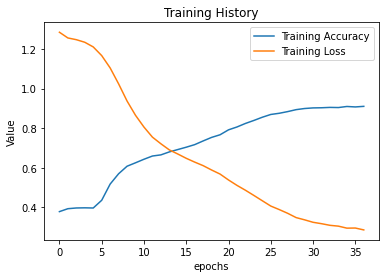

Initial training accuracy is:  0.3779231607913971
Final training accuracy is:  0.9101475477218628
Initial training loss is:  1.2848470211029053
Final training loss is:  0.2854408323764801


In [62]:
#Plotting model history
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", mlp_history.history['acc'][0])
print("Final training accuracy is: ", mlp_history.history['acc'][-1])

print("Initial training loss is: ", mlp_history.history['loss'][0])
print("Final training loss is: ", mlp_history.history['loss'][-1])

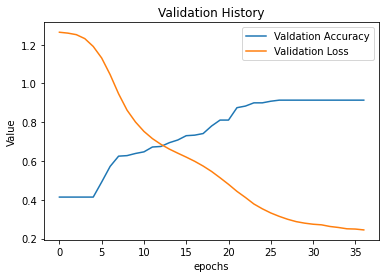

Initial validation accuracy is:  0.4138889014720917
Final validation accuracy is:  0.9138888716697693
Initial validation loss is:  1.2641679048538208
Final validation loss is:  0.24453839659690857


In [63]:
#Plotting model history
plt.plot(mlp_history.history['val_acc'])
plt.plot(mlp_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial validation accuracy is: ", mlp_history.history['val_acc'][0])
print("Final validation accuracy is: ", mlp_history.history['val_acc'][-1])

print("Initial validation loss is: ", mlp_history.history['val_loss'][0])
print("Final validation loss is: ", mlp_history.history['val_loss'][-1])


In [64]:
train_test_split = int(0.8 * len(xlstm))
print(train_test_split)

x_train_lstm = xlstm[:train_test_split]
y_train_lstm = ylstm[:train_test_split]

x_test_lstm = xlstm[train_test_split:]
y_test_lstm = ylstm[train_test_split:]


1440


In [65]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [66]:
train_batch_size = 32
train_cyclic_generator_lstm = get_cyclic_generator(x_train_lstm, y_train_lstm, batch_size = train_batch_size)
# test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

In [67]:
#Creating model architecture
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
lstm = tf.keras.layers.LSTM(32, return_sequences=True)(ip)
# drop = tf.keras.layers.Dropout(.4)(lstm)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
# drop = tf.keras.layers.Dropout(.4)(lstm)
flatten = tf.keras.layers.Flatten()(lstm)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.4)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

lstm = tf.keras.Model(inputs = ip, outputs = out)
lstm.summary()
# inp_shape = (None, )
# review_sequence = tf.keras.Input(shape = inp_shape)
# embedding_sequence = tf.keras.layers.Embedding(input_dim=100+1, output_dim=32, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
# average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
# positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

# model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 351, 61)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 351, 32)           12032     
_________________________________________________________________
flatten (Flatten)            (None, 11232)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                359456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528 

In [68]:
# Compiling the model
lstm_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'lstm_checkpoint/checkpoint_{epoch:02d}';
lstm_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

lstm.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [ ]:
lstm_history = lstm.fit(train_cyclic_generator_lstm,
                        validation_data = (x_test_lstm, y_test_lstm),
                        steps_per_epoch= 449,
                        epochs = 50,
#                         batch_size = 64,
                        callbacks = [lstm_earlystop, lstm_checkpoint]) #Fitting the model

Epoch 1/50
449/449 [==============================] - 63s 135ms/step - loss: 1.2717 - acc: 0.3760 - val_loss: 1.2698 - val_acc: 0.4139

Epoch 00001: val_acc improved from -inf to 0.41389, saving model to lstm_checkpoint/checkpoint_01
Epoch 2/50
449/449 [==============================] - 60s 135ms/step - loss: 1.2595 - acc: 0.3927 - val_loss: 1.2655 - val_acc: 0.4139

Epoch 00002: val_acc did not improve from 0.41389
Epoch 3/50
449/449 [==============================] - 61s 135ms/step - loss: 1.2549 - acc: 0.3963 - val_loss: 1.2650 - val_acc: 0.4139

Epoch 00003: val_acc did not improve from 0.41389
Epoch 4/50
449/449 [==============================] - 65s 144ms/step - loss: 1.2534 - acc: 0.3973 - val_loss: 1.2650 - val_acc: 0.4139

Epoch 00004: val_acc did not improve from 0.41389
Epoch 5/50
449/449 [==============================] - 62s 137ms/step - loss: 1.2507 - acc: 0.3957 - val_loss: 1.2519 - val_acc: 0.4139

Epoch 00005: val_acc did not improve from 0.41389
Epoch 6/50
 30/449 [=>

In [ ]:
#Plotting model history
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", lstm_history.history['acc'][0])
print("Final training accuracy is: ", lstm_history.history['acc'][-1])

print("Initial training loss is: ", lstm_history.history['loss'][0])
print("Final training loss is: ", lstm_history.history['loss'][-1])

In [ ]:
#Plotting model history
plt.plot(lstm_history.history['val_acc'])
plt.plot(lstm_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", lstm_history.history['val_acc'][0])
print("Final Validation accuracy is: ", lstm_history.history['val_acc'][-1])

print("Initial Validation loss is: ", lstm_history.history['val_loss'][0])
print("Final Validation loss is: ", lstm_history.history['val_loss'][-1])

In [ ]:
train_test_split = int(0.8 * len(xcnn))
print(train_test_split)

x_train_cnn = xcnn[:train_test_split]
y_train_cnn = ycnn[:train_test_split]

x_test_cnn = xcnn[train_test_split:]
y_test_cnn = ycnn[train_test_split:]

In [ ]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]


In [ ]:
train_batch_size = 32
train_cyclic_generator_cnn = get_cyclic_generator(x_train_cnn, y_train_cnn, batch_size = train_batch_size)
# test_cyclic_generator = get_cyclic_generator(x_test, y_test, batch_size = train_batch_size)

In [ ]:
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3,)(ip)
rel = tf.keras.layers.LeakyReLU()(conv1)
conv2 = tf.keras.layers.Conv1D(16, 3,)(rel)
rel2 = tf.keras.layers.LeakyReLU()(conv2)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(rel2)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.4)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

cnn = tf.keras.Model(inputs = ip, outputs = out)
cnn.summary()

In [ ]:
# Compiling the model
cnn_earlystop = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'val_acc')

path = 'cnn_checkpoint/checkpoint_{epoch:02d}';
cnn_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

cnn.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')